# Part 4: Manual Homography + Stitching

Implementation Details:
i) The GUI has been created for user to select 4 points from each image that is displayed. The 2nd image is interpolated in order to prevent darkening effect produced from transformation. The selected coordinates for this image are scaled accordingly s well.
ii) Once coordinates have been selected and scaled as per requirement, the homography matrix is computed so as to bring about transformation of image coordinates. Since 2nd image is being stitched to the 1st image, the inverse of the homography matrix is considered for transformation.
iii)  Canvas is created by making use of transformations of extreme coordinates of the 2nd image. In this way all the other coordinates which are smaller in value can be accomodated in the canvas and stttched completely without the occurence of cutting off of any part of the image to be stitched.
iv) Once canvas is created, the 1st image is placed upon the canvas and the 2nd image is transformed and stitched accordingly.

In [430]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy.linalg as lin

from skimage.transform import warp

In [431]:
from tkinter import *
from PIL import Image, ImageTk

In [432]:
def get_x_and_y(event):
    global coordinates_1
    global lasx, lasy
    
    lasx, lasy = event.x, event.y
    coordinates_1.append([lasx,lasy])
    print(lasx,lasy)

#coordinates_2=[]
def get_x_and_y1(event):
    global lasx1, lasy1
    global coordinates_2
    lasx1, lasy1 = event.x, event.y
    coordinates_2.append([lasx1,lasy1])
    print(lasx1,lasy1)

In [495]:
coordinates_1=[]

app = Tk()
app.geometry("640x480")
canvas = Canvas(app, bg='black')
canvas.pack(anchor='nw', fill='both', expand=1)

canvas.bind("<Button-1>", get_x_and_y)
# canvas = Canvas(app, bg='black')
# canvas.pack(anchor='nw', fill='both', expand=1)

# canvas.bind("<Button-1>", get_x_and_y)
#canvas.bind("<B1-Motion>", draw_smth)
image = Image.open("im01.jpg")
#image = image.resize((400,400), Image.ANTIALIAS)
image = ImageTk.PhotoImage(image,master=app)
canvas.create_image(0,0, image=image, anchor='nw')

app.mainloop()



306 447
299 249
502 245
514 439


In [496]:
coordinates_2=[]
#587, 850
app1 = Tk()
app1.geometry("640x480")
canvas1 = Canvas(app1, bg='black')
canvas1.pack(anchor='nw', fill='both', expand=1)

canvas1.bind("<Button-1>", get_x_and_y1)
image1 = Image.open("im02.jpg")
#image1 = image1.resize((600,400), Image.ANTIALIAS)
image1 = ImageTk.PhotoImage(image1,master=app1)
canvas1.create_image(0,0, image=image1, anchor='nw')
app1.mainloop()

52 437
50 251
275 256
296 442


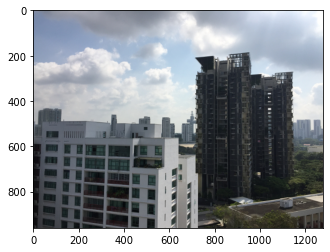

In [474]:
im1=plt.imread('im02.jpg')
im1_interpolate=cv2.resize(im1,(2*im1.shape[1],2*im1.shape[0]),fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
plt.imshow(im1_interpolate)

In [497]:
coordinates_scaled=[]
for i in coordinates_2:
    print(i[0],i[1])
    coordinates_scaled.append([2*i[0],2*i[1]])


52 437
50 251
275 256
296 442


In [500]:
import numpy as np
A = []
b = []
for i in range(len(coordinates_1)):
    s_x, s_y = coordinates_1[i]
    d_x, d_y = coordinates_scaled[i]
    A.append([s_x, s_y, 1, 0, 0, 0, -(d_x)*(s_x), -(d_x)*(s_y),-d_x])
    A.append([0, 0, 0, s_x, s_y, 1, -(d_y)*(s_x), -(d_y)*(s_y),-d_y])
    b += [d_x, d_y]
A = np.array(A)
#h = np.linalg.lstsq(A, b,rcond=-1)[0]
#h = np.concatenate((h, [1]), axis=-1)

import scipy.linalg as linalg
A = np.array(A)
U, Sigma, V_transpose = linalg.svd(A)

H = np.reshape(V_transpose[-1], (3,3))
H

array([[-4.06324917e-03,  1.59184990e-04,  9.87908583e-01],
       [-7.17412151e-05, -3.06901915e-03, -1.54940210e-01],
       [ 1.68260424e-07,  5.07382695e-07, -2.05030673e-03]])

In [501]:
H_inv=linalg.pinv(H)

In [502]:
h2,w2=im1_interpolate.shape[0:2]
h2,w2

(960, 1280)

In [503]:
vertex = np.array([[0, 0, 1], [0, h2, 1], [w2, 0, 1], [w2, h2, 1]]);
pos = np.dot(H_inv ,vertex.T); #position of transformed vertices

In [504]:
row=(pos[1,:]/pos[2,:]).astype(int)
col=(pos[0,:]/pos[2,:]).astype(int)

In [505]:
col_min = min(col)
col_max = max(col)
row_min = min(row)
row_max = max(row);

In [506]:
if row_min>0:
    row_min=1
if col_min>0:
    col_min=1

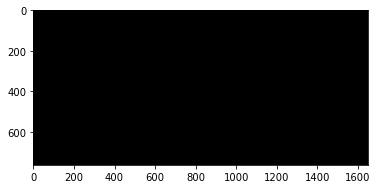

In [514]:
canvas1 = np.zeros([row_max-row_min+200, col_max-col_min+800, 3])
canvas1.shape
plt.imshow(canvas1)

In [509]:
f2=plt.imread('im01.jpg')

In [209]:
row_min

-162

In [210]:
if row_min>0:
    row_min=1
if col_min>0:
    col_min=1



In [515]:

for y in range(0,f2.shape[0]):
    
    for x in range(0,f2.shape[1]):
        
        tx2 = x-col_min
        ty2 = y-row_min
        if ty2<canvas1.shape[0] and tx2<canvas1.shape[1]:
            canvas1[ty2,tx2] = f2[y,x]

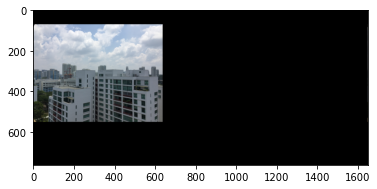

In [516]:
plt.imshow(canvas1/255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


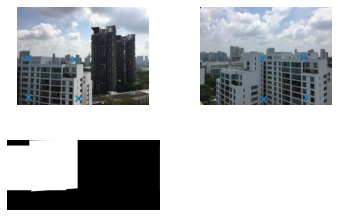

In [517]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy.linalg as lin

from skimage.transform import warp

# Image read
#canvas1 = np.zeros([row_max-row_min+1, col_max-col_min+1, 3])

f1 = plt.imread('im02.jpg') 
f2 = plt.imread('im01.jpg') 

# # Setting matching points in first image
# xy_1 = np.array([[128, 186], [430, 61], [545, 153], [245, 309]])  # x4[3][0], y4[3][1]

# # Setting matching points in second image
# xy_2 = np.array([[136, 90], [910, 54], [926, 643], [166, 669]])  # x'4[3][0], y'4[3][1]

# # Get homography matrix with cv2 module
# #cv2_Homography = cv2.getPerspectiveTransform(xy_1.astype(np.float32), xy_2.astype(np.float32))

# # Make homography matrix
# # Make matrix A
# arrayA = np.array([[xy_1[0][0], xy_1[0][1], 1, 0, 0, 0, -xy_1[0][0] * xy_2[0][0], -xy_1[0][1] * xy_2[0][0]],
#                    [0, 0, 0, xy_1[0][0], xy_1[0][1], 1, -xy_1[0][0] * xy_2[0][1], -xy_1[0][1] * xy_2[0][1]],
#                    [xy_1[1][0], xy_1[1][1], 1, 0, 0, 0, -xy_1[1][0] * xy_2[1][0], -xy_1[1][1] * xy_2[1][0]],
#                    [0, 0, 0, xy_1[1][0], xy_1[1][1], 1, -xy_1[1][0] * xy_2[1][1], -xy_1[1][1] * xy_2[1][1]],
#                    [xy_1[2][0], xy_1[2][1], 1, 0, 0, 0, -xy_1[2][0] * xy_2[2][0], -xy_1[2][1] * xy_2[2][0]],
#                    [0, 0, 0, xy_1[2][0], xy_1[2][1], 1, -xy_1[2][0] * xy_2[2][1], -xy_1[2][1] * xy_2[2][1]],
#                    [xy_1[3][0], xy_1[3][1], 1, 0, 0, 0, -xy_1[3][0] * xy_2[3][0], -xy_1[3][1] * xy_2[3][0]],
#                    [0, 0, 0, xy_1[3][0], xy_1[3][1], 1, -xy_1[3][0] * xy_2[3][1], -xy_1[3][1] * xy_2[3][1]]])
# M_A = np.asmatrix(arrayA)

# # transpose matrix A
# M_At = M_A.T

# # Make matrix b
# arrayB = np.array([[xy_2[0][0]],
#                    [xy_2[0][1]],
#                    [xy_2[1][0]],
#                    [xy_2[1][1]],
#                    [xy_2[2][0]],
#                    [xy_2[2][1]],
#                    [xy_2[3][0]],
#                    [xy_2[3][1]]])
# M_B = np.asmatrix(arrayB)

# # Make homography matrix
# My_Homography = np.asarray((M_At * M_A).I * (M_At * M_B))

# My_Homography_arr = np.array([[My_Homography[0][0], My_Homography[1][0], My_Homography[2][0]],
#                               [My_Homography[3][0], My_Homography[4][0], My_Homography[5][0]],
#                               [My_Homography[6][0], My_Homography[7][0], 1]])

# # My_homography's inverse
# inv_my_homo = lin.inv(My_Homography_arr)

# # Homographic transformation with cv2 module
# # cv2_warped = warp(f2, cv2_Homography, output_shape=(300, 550))

# # Make blank image
#warped = np.zeros((700, 1200, 3), np.float32)
h2,w2=im1_interpolate.shape[0:2]
# Make warping source
for y in range(0, h2):
    for x in range(0, w2):
        pixel = np.array([x,
                          y,
                          1])

        # Resource_pixel = np.asarray(np.asmatrix(inv_my_homo) * np.asmatrix(pixel))
        #Resource_pixel = np.asarray(np.asmatrix(My_Homography_arr) * np.asmatrix(pixel))
        Resource_pixel = np.asarray(H_inv * np.asmatrix(pixel).T)
        # Coordinate scale
        trans_x = Resource_pixel[0][0] / Resource_pixel[2][0]
        trans_y = Resource_pixel[1][0] / Resource_pixel[2][0]

        # Continue that pixels not matched
#         if (trans_x < 0 or trans_y < 0
#                 or trans_x > f2.shape[0] - 1 or trans_y > f2.shape[1] - 1):
            
# #        if (trans_x < 0 and trans_y < 0
# #                 and trans_x > f2.shape[0] - 1 and trans_y > f2.shape[1] - 1):
#              continue

        # divided by two parts with integer & decimal number
        tx = int(trans_x) -col_min
        ty = int(trans_y) -row_min
        a = trans_x - tx
        b = trans_y - ty
        
        if tx<canvas1.shape[0] and ty<canvas1.shape[1]:
            canvas1[ty,tx]=im1_interpolate[y,x]

        # Bilinear Interpolation
#         warped[y][x] = ((((1.0 - a) * (1.0 - b)) * f2[ty][tx])
#                         + ((a * (1.0 - b)) * f2[ty][tx + 1])
#                         + ((a * b) * f2[ty + 1][tx + 1])
#                         + (((1.0 - a) * b) * f2[ty + 1][tx]))

# Image stitch
# M, N = f1.shape[:2]
# f_stitched = np.copy(warped)
#f_stitched[0:M, 0:N, :] = f1

# Plot
plt.subplot(221)
plt.imshow(f1)
plt.axis('off')
coordinates_2=np.array(coordinates_2)
coordinates_1=np.array(coordinates_1)
plt.scatter(coordinates_2[:, 0], coordinates_2[:, 1], marker='x')
plt.subplot(222)
plt.imshow(f2)
plt.axis('off')
plt.scatter(coordinates_1[:, 0], coordinates_1[:, 1], marker='x')
plt.subplot(223)
plt.imshow(canvas1)
plt.axis('off')
#plt.subplot(224)
#plt.imshow(f_stitched)
#plt.axis('off')
plt.show()


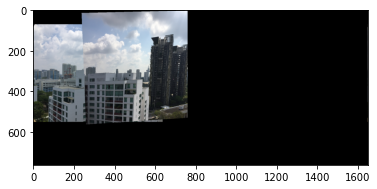

In [518]:
plt.imshow(canvas1/255)

From the above output, it can be seen that double edges occur at the overlapping region due to geometric misalignment and change in pixel values. Geometric misalignment is caused due to capturing of images from different planes, from different viewpoints and under different lighting conditions as a result of which the points for the same object could have different locations and different variations as a result of which it may not be possible for an image to be stitched with exact and accurate overlap over the other image and thus can result in the occurence if double edges.